In [390]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
from sklearn import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
import keras.optimizers
from keras.callbacks import Callback
import time

import scipy.io as sc
from sklearn.metrics import mean_squared_error, r2_score

EMBEDDING_SIZE = 24
LEARNING_RATE = 0.001
BATCH_SIZE = 7*24
NUM_UNITS = 128
NUM_DENSE = 32

In [391]:
# download the data
f = sc.loadmat('data_new.mat')
vals = f['data_new'][0,0]
keys = f['data_new'][0,0].dtype.descr
f['data_new'][0,0]["Y"].shape

# get the values from the struct
data = {}
for i in range(len(keys)-1):
    key = keys[i][0]
    data[str(key)] = vals[key]

datafrm = {"Temperature": data["X"][0,:].reshape(-1), "Turbidity": data["X"][1,:].reshape(-1), "Chlorophyll": data["X"][2,:].reshape(-1), "TargetChlorophyll": data["Y"].reshape(-1)}
data = pd.DataFrame(data=datafrm)
'''
# visualize the data
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
plt.subplot(3,1,1)
plt.plot(data["Temperature"],c='black')
plt.title("Temperature")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(data["Turbidity"],c='black')
plt.title("Turbidity")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(data["Chlorophyll"],c='black')
plt.title("Chlorophyll")

plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()
print(data.shape)'''

'\n# visualize the data\nplt.figure(figsize=(15,5))\nplt.gca().xaxis.set_major_formatter(mdates.DateFormatter(\'%Y-%m-%d\'))\nplt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))\nplt.subplot(3,1,1)\nplt.plot(data["Temperature"],c=\'black\')\nplt.title("Temperature")\nplt.grid(True)\n\nplt.subplot(3,1,2)\nplt.plot(data["Turbidity"],c=\'black\')\nplt.title("Turbidity")\nplt.grid(True)\n\nplt.subplot(3,1,3)\nplt.plot(data["Chlorophyll"],c=\'black\')\nplt.title("Chlorophyll")\n\nplt.gcf().autofmt_xdate()\nplt.grid(True)\nplt.show()\nprint(data.shape)'

In [392]:
# split the data into train and test partitions, use 94% first samples as test data and rest as train data
Tp = 15977 # test samples
Tv = 850 # number of validation samples
values = data.values.astype(np.float32)
train,test = values[0:Tp,:], values[Tp:,:]

# normalize the data, use train set normalization for test set
scaler = preprocessing.StandardScaler()
train_scaler = scaler.fit(train)
data_norm = train_scaler.transform(values).reshape(-1,4)

#data_norm = pd.DataFrame(data_norm, columns=["Value"])
# visualize the data again with test and training samples separated
index = data.index.values
'''
plt.figure(figsize=(15,5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=500))
plt.subplot(3,1,1)
plt.plot(index[0:Tp],data_norm[:Tp,0],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,0],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,0],c='orange',alpha=0.7)
plt.title("Normalized Temperature")
plt.grid(True)

plt.subplot(3,1,2)
plt.plot(index[0:Tp],data_norm[:Tp,1],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,1],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,1],c='orange',alpha=0.7)
plt.title("Normalized Turbidity")
plt.grid(True)

plt.subplot(3,1,3)
plt.plot(index[0:Tp],data_norm[:Tp,2],c='blue')
plt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,2],c='green')
plt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,2],c='orange',alpha=0.7)
plt.legend(['Train','Validation', 'Test'])
plt.title("Normalized Chlorophyll")
plt.gcf().autofmt_xdate()
plt.grid(True)
plt.show()
'''

'\nplt.figure(figsize=(15,5))\nplt.gca().xaxis.set_major_formatter(mdates.DateFormatter(\'%Y-%m-%d\'))\nplt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=500))\nplt.subplot(3,1,1)\nplt.plot(index[0:Tp],data_norm[:Tp,0],c=\'blue\')\nplt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,0],c=\'green\')\nplt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,0],c=\'orange\',alpha=0.7)\nplt.title("Normalized Temperature")\nplt.grid(True)\n\nplt.subplot(3,1,2)\nplt.plot(index[0:Tp],data_norm[:Tp,1],c=\'blue\')\nplt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,1],c=\'green\')\nplt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,1],c=\'orange\',alpha=0.7)\nplt.title("Normalized Turbidity")\nplt.grid(True)\n\nplt.subplot(3,1,3)\nplt.plot(index[0:Tp],data_norm[:Tp,2],c=\'blue\')\nplt.plot(index[Tp:Tp + Tv],data_norm[Tp:Tp + Tv,2],c=\'green\')\nplt.plot(index[Tp+Tv:],data_norm[Tp+Tv:,2],c=\'orange\',alpha=0.7)\nplt.legend([\'Train\',\'Validation\', \'Test\'])\nplt.title("Normalized Chlorophyll")\nplt.gcf().autofmt_xda

In [393]:
# define the embeddig size
step = EMBEDDING_SIZE
# split the data
train_norm = data_norm[:Tp,:]
val_norm = data_norm[Tp:Tp+Tv,:]
test_norm = data_norm[Tp+Tv:,:]

# add step elements into train and test
#test_norm = np.append(test_norm,np.repeat(test_norm[-1,:],step).reshape(-1,EMBEDDING_SIZE).T, axis=0)
#val_norm = np.append(val_norm,np.repeat(val_norm[-1,:],step).reshape(-1,EMBEDDING_SIZE).T, axis=0)
#train_norm = np.append(train_norm,np.repeat(train_norm[-1,:],step).reshape(-1,EMBEDDING_SIZE).T, axis=0)

# check the sizes
print("Train data length:", train_norm.shape)
print("Val data length:", val_norm.shape)
print("Test data length:", test_norm.shape)



Train data length: (15997, 4)
Val data length: (850, 4)
Test data length: (150, 4)


In [394]:
# define the data as matrices
def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,:3])
        Y.append(data[d-1,3])
    return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train_norm,step)
valX,valY =convertToMatrix(val_norm,step)
testX,testY =convertToMatrix(test_norm,step)

#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[2], trainX.shape[1]))
#valX = np.reshape(valX, (valX.shape[0], valX.shape[2], valX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], testX.shape[2], testX.shape[1]))

print("Training data shape:", trainX.shape,', ',trainY.shape)
print("Validation data shape:", valX.shape,', ',valY.shape)
print("Test data shape:", testX.shape,', ',testY.shape)

Training data shape: (15973, 24, 3) ,  (15973,)
Validation data shape: (826, 24, 3) ,  (826,)
Test data shape: (126, 24, 3) ,  (126,)


In [395]:
# check point so that only the model with smalles validation loss is saved
cp = ModelCheckpoint('RNN_model/', save_best_only=True)

# define the RNN model
def build_simple_rnn(num_units=NUM_UNITS, embedding=EMBEDDING_SIZE,num_dense=NUM_DENSE,lr=LEARNING_RATE):
    """
    Builds and compiles a simple RNN model
    Arguments:
              num_units: Number of units of a the simple RNN layer
              embedding: Embedding length
              num_dense: Number of neurons in the dense layer followed by the RNN layer
              lr: Learning rate (uses RMSprop optimizer)
    Returns:
              A compiled Keras model.
    """
    model = Sequential()
    model.add(SimpleRNN(units=num_units, input_shape=(embedding,3), activation="relu"))
    model.add(Dense(num_dense, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.legacy.RMSprop(lr=lr),metrics=['mse'])
    
    return model

model = build_simple_rnn() # Taking the defaults
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_36 (SimpleRNN)   (None, 128)               16896     
                                                                 
 dense_72 (Dense)            (None, 32)                4128      
                                                                 
 dense_73 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [397]:
batch_size = BATCH_SIZE
num_epochs = 50

# train the model
start = time.time()
model.fit(trainX,trainY, 
          epochs=num_epochs, 
          batch_size=batch_size, 
          callbacks=[cp],
          verbose=1,
          validation_data=(valX, valY))

end = time.time()
print("Training time " + str(end-start))
# load the saved model
RNN_model_best = load_model('RNN_model/')

Epoch 1/50
93/96 [============================>.] - ETA: 0s - loss: 0.1414 - mse: 0.1414INFO:tensorflow:Assets written to: RNN_model/assets


INFO:tensorflow:Assets written to: RNN_model/assets


96/96 [==============================] - 2s 13ms/step - loss: 0.1393 - mse: 0.1393 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/50
91/96 [===========================>..] - ETA: 0s - loss: 0.0833 - mse: 0.0833INFO:tensorflow:Assets written to: RNN_model/assets


INFO:tensorflow:Assets written to: RNN_model/assets


96/96 [==============================] - 1s 12ms/step - loss: 0.0806 - mse: 0.0806 - val_loss: 7.4177e-04 - val_mse: 7.4177e-04
Epoch 3/50
92/96 [===========================>..] - ETA: 0s - loss: 0.0769 - mse: 0.0769INFO:tensorflow:Assets written to: RNN_model/assets


INFO:tensorflow:Assets written to: RNN_model/assets


96/96 [==============================] - 2s 18ms/step - loss: 0.0766 - mse: 0.0766 - val_loss: 2.9273e-04 - val_mse: 2.9273e-04
Epoch 4/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0785 - mse: 0.0785 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 5/50
92/96 [===========================>..] - ETA: 0s - loss: 0.0711 - mse: 0.0711INFO:tensorflow:Assets written to: RNN_model/assets


INFO:tensorflow:Assets written to: RNN_model/assets


96/96 [==============================] - 1s 12ms/step - loss: 0.0695 - mse: 0.0695 - val_loss: 1.8100e-04 - val_mse: 1.8100e-04
Epoch 6/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0677 - mse: 0.0677 - val_loss: 6.7432e-04 - val_mse: 6.7432e-04
Epoch 7/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0657 - mse: 0.0657 - val_loss: 3.4266e-04 - val_mse: 3.4266e-04
Epoch 8/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0651 - mse: 0.0651 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 9/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0605 - mse: 0.0605 - val_loss: 4.0698e-04 - val_mse: 4.0698e-04
Epoch 10/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0591 - mse: 0.0591 - val_loss: 8.5478e-04 - val_mse: 8.5478e-04
Epoch 11/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0555 - mse: 0.0555 - val_loss: 3.8455e-04 - val_mse: 3.8455e-04
Epoch 12/50
96/96 [==============================]

INFO:tensorflow:Assets written to: RNN_model/assets


96/96 [==============================] - 1s 13ms/step - loss: 0.0449 - mse: 0.0449 - val_loss: 5.6289e-05 - val_mse: 5.6289e-05
Epoch 20/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0402 - mse: 0.0402 - val_loss: 2.5856e-04 - val_mse: 2.5856e-04
Epoch 21/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0406 - mse: 0.0406 - val_loss: 2.0438e-04 - val_mse: 2.0438e-04
Epoch 22/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0357 - mse: 0.0357 - val_loss: 6.8460e-05 - val_mse: 6.8460e-05
Epoch 23/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0360 - mse: 0.0360 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 24/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0279 - mse: 0.0279 - val_loss: 9.1277e-05 - val_mse: 9.1277e-05
Epoch 25/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0338 - mse: 0.0338 - val_loss: 1.1946e-04 - val_mse: 1.1946e-04
Epoch 26/50
96/96 [===========================

INFO:tensorflow:Assets written to: RNN_model/assets


96/96 [==============================] - 1s 13ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 2.7047e-05 - val_mse: 2.7047e-05
Epoch 29/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 4.3490e-05 - val_mse: 4.3490e-05
Epoch 30/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 2.9324e-04 - val_mse: 2.9324e-04
Epoch 31/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 9.1554e-05 - val_mse: 9.1554e-05
Epoch 32/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 33/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0291 - mse: 0.0291 - val_loss: 7.3291e-05 - val_mse: 7.3291e-05
Epoch 34/50
96/96 [==============================] - 1s 8ms/step - loss: 0.0241 - mse: 0.0241 - val_loss: 2.2649e-04 - val_mse: 2.2649e-04
Epoch 35/50
96/96 [===========================

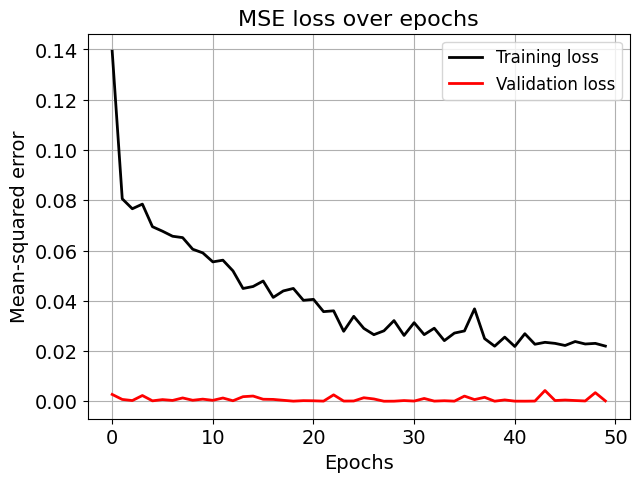

In [398]:
# visualize the losses over the epochs
plt.figure(figsize=(7,5))
plt.title("MSE loss over epochs",fontsize=16)
plt.plot((model.history.history['loss']),c='k',lw=2, label="Training loss")
plt.plot((model.history.history['val_loss']),c='r',lw=2, label="Validation loss")
plt.grid(True)
plt.xlabel("Epochs",fontsize=14)
plt.legend(fontsize=12)
plt.ylabel("Mean-squared error",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [399]:
# test the model
validation_target = testY
validation_predictions = []
# use last value before test partition as the input parameter for the model
last_x = valX[-1,:,:]

# help index so we can get the correct temperature and turbidity values for input sample
testInd = 0
while len(validation_predictions) < len(validation_target):
  # predict
  p = RNN_model_best.predict(last_x.reshape(1,EMBEDDING_SIZE,3), verbose=1)[0,0]
  validation_predictions.append(p)
  # add the predicted chlorophyll value to the chlorophyll value with actual temperature and turbidity values
  last_x = np.roll(last_x, -1, axis=0)
  last_x[-1,0] = testX[testInd,-1,0]
  last_x[-1,1] = testX[testInd,-1,1]
  last_x[-1,2] = p
  testInd = testInd + 1


1/1 [==============================] - 0s 11ms/step


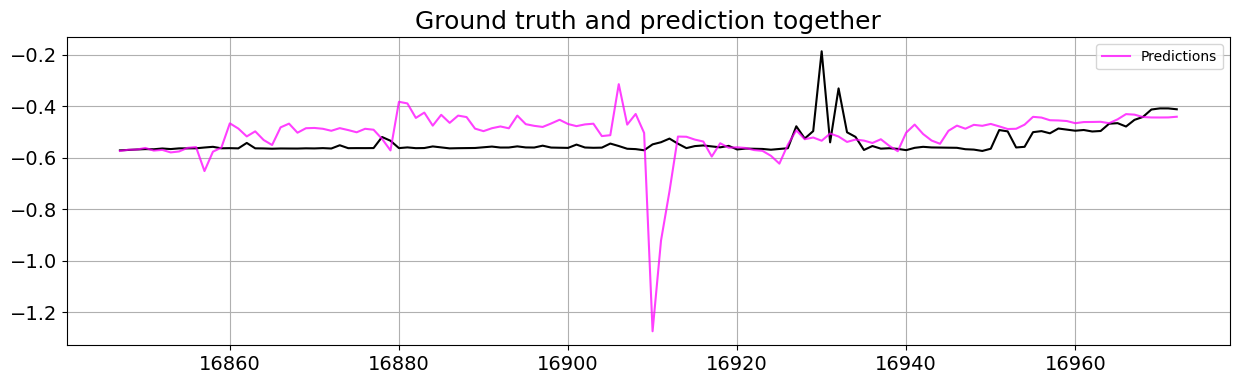

In [405]:
# visualize the ground truth and the prediction together
index = data.index.values
train_index = index[:Tp]
val_index = index[Tp:Tp+Tv]
test_index = index[Tp+Tv:]

plt.figure(figsize=(15,4))
plt.title("Ground truth and prediction together",fontsize=18)

plt.plot(test_index[:-EMBEDDING_SIZE], data_norm[test_index[:-EMBEDDING_SIZE],3],c='black')
plt.plot(test_index[:-EMBEDDING_SIZE], validation_predictions, c='magenta',alpha=0.75, label="Predictions")
#plt.plot(test_index[:15], validation_predictions[:15], c='magenta',alpha=0.75, label="Predictions")

plt.legend(fontsize=10)
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([-1, 0.2])
plt.show()

In [401]:
# Evaluate the model
mse = mean_squared_error(validation_target, validation_predictions)
r2 = r2_score(validation_target, validation_predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.017104854807257652
R-squared: -0.3212363488203218
